# EDA on full dataset 

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)

import numpy as np
import pickle
import matplotlib.pyplot as plt
import gensim
import time

from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
#from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

#import spacy
#from spacy.lang.en.stop_words import STOP_WORDS

from importlib import reload

/home/kjl5t/.local/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
# pull in data

# full corpus
#df = pd.read_pickle("../../data/prd/Federal_RePORTER/FR-cleaned-2021FEB24.pkl")
df = pd.read_pickle("/home/kjl5t/dspg21RnD/data/dspg21RnD/smaller-final-dataset.pkl")



In [3]:
df.head()

,original index,PROJECT_ID,ABSTRACT,FY,ORG_COUNT,PI_COUNT,nchar,final_frqwds_removed,PROJECT_TERMS,PROJECT_TITLE,DEPARTMENT,AGENCY,IC_CENTER,PROJECT_NUMBER,PROJECT_START_DATE,PROJECT_END_DATE,CONTACT_PI_PROJECT_LEADER,OTHER_PIS,CONGRESSIONAL_DISTRICT,DUNS_NUMBER,ORGANIZATION_NAME,ORGANIZATION_CITY,ORGANIZATION_STATE,ORGANIZATION_ZIP,ORGANIZATION_COUNTRY,BUDGET_START_DATE,BUDGET_END_DATE,CFDA_CODE,FY.y,FY_TOTAL_COST,FY_TOTAL_COST_SUB_PROJECTS
0,17608,152242,The multiprotein complex y-secretase proteolyt...,2008,1,1,1402,"[multiprotein, y_secretase, proteolytically_cl...",Active Sites; Affect; Alzheimer's Disease; Am...,STRUCTURE OF SIGNAL PEPTIDE PEPTIDASE,HHS,NIH,NIA,5F32AG027647-03,12/1/2005,1/1/2008,"LIEBERMAN, RAQUEL L",NaN,07,030811269,BRIGHAM AND WOMEN'S HOSPITAL,BOSTON,MA,021156110,UNITED STATES,12/1/2007,1/1/2008,93.866,2008,3483.0,NaN
1,111864,190316,DESCRIPTION (provided by applicant): The Kis...,2008,1,1,2553,"[kissl, gene, encode, peptide, kisspeptin, bin...",Affect; Animal Model; Axon; Behavior; Behavio...,ROLE OF KISS1 NEURONS IN THE SEASONAL AND CIRC...,HHS,NIH,NICHD,5K99HD056157-02,9/1/2007,1/1/2009,"KAUFFMAN, ALEXANDER S",NaN,07,605799469,UNIVERSITY OF WASHINGTON,SEATTLE,WA,981959472,UNITED STATES,9/1/2008,1/1/2009,93.865,2008,39175.0,NaN
2,22052,154213,DESCRIPTION (provided by applicant): The objec...,2008,1,1,1414,"[biophysical, basis, thermodynamics_kinetic, m...",Agreement; Antibodies; base; Binding; Biochem...,CARBONIC ANHYDRASE AS A MODEL TO UNDERSTAND DI...,HHS,NIH,NIGMS,5F32GM076971-02,1/2/2007,1/1/2009,"MACK, ERIC T",NaN,05,082359691,HARVARD UNIVERSITY,CAMBRIDGE,MA,021385319,UNITED STATES,1/2/2008,1/1/2009,93.859,2008,49646.0,NaN
3,35004,159362,Obesity is the cause of many adverse pregnancy...,2008,1,1,1545,"[obesity, adverse_pregnancyoutcome, great, hea...",African; Analysis of Variance; Asians; Birth;...,OBESITY ON VAGAL TONE AND HBA1C DURING PREGNANCY,HHS,NIH,NINR,5F31NR009611-03,4/1/2006,1/1/2009,"HELMREICH, REBECCA J",NaN,09,800771594,UNIVERSITY OF TEXAS HLTH SCI CTR HOUSTON,HOUSTON,TX,770305400,UNITED STATES,4/1/2008,1/1/2009,93.361,2008,20406.0,NaN
4,371628,594482,Local potato advisory groups have expressed in...,2010,1,1,271,"[local, potato, advisory, express, interest, m...",cost; Health; interest; Manure; Parasitic nem...,PLANT-PARASITIC NEMATODE MANAGEMENT AS A COMPO...,USDA,NIFA,NaN,0219605,10/1/2009,1/1/2010,"CHARLTON, B.",NaN,NaN,053599908,OREGON STATE UNIVERSITY,CORVALLIS,OR,97331,UNITED STATES,NaN,NaN,10.203,2010,NaN,NaN


In [4]:
# agency distribution

df["DEPARTMENT"].value_counts()

HHS     511793
NSF     121715
USDA     29769
NASA     10853
DOD       7845
VA        5529
ED        1764
EPA       1540
Name: DEPARTMENT, dtype: int64

In [5]:
len(df)

690814

In [6]:
agency_counts = 100*df["DEPARTMENT"].value_counts()/len(df)
print(agency_counts)

HHS     74.085499
NSF     17.619070
USDA     4.309264
NASA     1.571045
DOD      1.135617
VA       0.800360
ED       0.255351
EPA      0.222925
Name: DEPARTMENT, dtype: float64


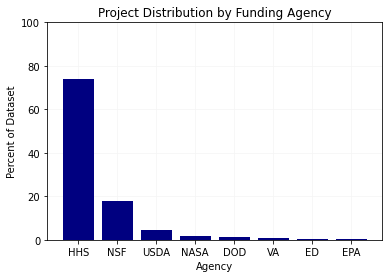

In [7]:
# plot
agency = agency_counts.index.tolist()
count = agency_counts.values

#reload(plt)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(agency, count, color='navy')
plt.ylim(0,100)
plt.xlabel("Agency")
plt.ylabel("Percent of Dataset")
plt.title("Project Distribution by Funding Agency")

#plt.savefig("figures/agency_dist.png", dpi = 800, bbox_inches = "tight")

In [8]:
# project start year distribution

#sum(df["PROJECT_START_DATE"].isna())  #0

# Extract Year from PROJECT_START_DATE - Sean's function from emerging topics code

def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)


In [9]:
df["START_YEAR"] = df["START_YEAR"].astype('int')

In [10]:
df['START_YEAR'].value_counts()

2009    70326
2010    65361
2011    59065
2008    56133
2012    52137
2014    45773
2016    44917
2015    44798
2013    43666
2018    43224
2017    41733
2019    31166
2007    18138
2006    10509
2005     9521
2004     8038
2003     5093
1997     4507
2002     4486
2001     4406
2000     3635
1999     3475
1998     2677
1996     1851
1994     1598
1995     1436
1992     1269
1993     1179
1991     1136
1988      913
1990      845
1989      840
1987      704
1986      675
1985      665
1978      639
1983      637
1984      598
1977      506
1975      490
1979      463
1980      438
1982      393
1981      341
1976      336
2020       33
1974       32
1972        4
1970        4
1965        4
1973        1
Name: START_YEAR, dtype: int64

In [11]:
# number of projects with a start year before 2008

#df.dtypes
print(len(df[df['START_YEAR'] < 2008]))
print(100*len(df[df['START_YEAR'] < 2008])/len(df))

92482
13.3873951599128


In [41]:
# projects with start year of at least 2008

filt_df = df[df['START_YEAR'] >= 2008]
filt_df = filt_df[filt_df['START_YEAR'] < 2020]

In [42]:
year_counts = filt_df["START_YEAR"].value_counts()
print(year_counts)

2009    70326
2010    65361
2011    59065
2008    56133
2012    52137
2014    45773
2016    44917
2015    44798
2013    43666
2018    43224
2017    41733
2019    31166
Name: START_YEAR, dtype: int64


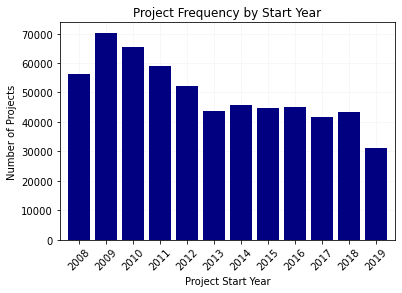

In [47]:
# plot
year = year_counts.index.tolist()
count = year_counts.values

fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_axisbelow(True)
plt.grid(True, color = "whitesmoke")
plt.bar(year, count, color='navy')
plt.xlim(2007.3, 2019.7)
plt.xticks(year, rotation=45)
#x_ticks = ax.xaxis.get_major_ticks()
#x_ticks[-1].label1.set_visible(False)
plt.xlabel("Project Start Year")
plt.ylabel("Number of Projects")
plt.title("Project Frequency by Start Year")

plt.savefig("figures/startyr_freq.png", dpi = 800, bbox_inches = "tight")